In [114]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization
from librosa.core import stft
import matplotlib.pyplot as plot
import matplotlib.cm as cm

In [3]:
def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [126]:
X_data = np.zeros(shape=(55000,45056))
print(X_data.shape)

for r in range(0, 55000):
    audio = readwav('/Users/josephcleveland/Dataset/samp' + str(r) + '.wav')[2]
    audio = audio.T[0]
    if(audio.shape != 45056):
        padded = np.zeros(shape=(45056))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    X_data[r] = audio
    


(55000, 45056)


/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(705, 65)


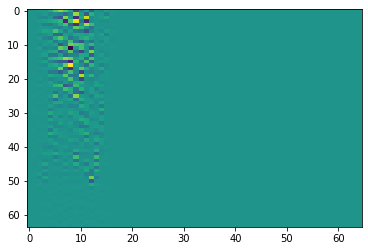

In [170]:
spect = stft(X_data[200],n_fft=1408, hop_length=703)
print(spect.shape)
plot.imshow(spect.real[0:64], aspect='auto')
plot.show()

In [127]:
Y_data = np.zeros(shape=(55000, 368))
mat = np.genfromtxt('/Users/josephcleveland/Dataset/mat.txt', delimiter=',')
for i in range(0, 55000):
    onehot = to_categorical(mat[i], 16)
    Y_data[i] = onehot.ravel()

In [128]:
#X_data = signal.resample(X_data, 16384)
X_train = np.zeros((55000, 64, 64))
for i in range(0, 55000):
    X_train[i] = stft(X_data[i],n_fft=1408, hop_length=704)[0:64, 0:64]
Y_train = Y_data
X_train = np.expand_dims(X_train, axis=3)

print(X_train.shape)

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


(55000, 64, 64, 1)


In [458]:
#model = Sequential()
#model.add(BatchNormalization())
#model.add(Convolution2D(96, kernel_size=(64, 1), strides=(4, 1), padding="valid", activation='relu', data_format="channels_last", input_shape=(16384, 1, 1)))
#model.add(Convolution2D(96, kernel_size=(32, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(16, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Convolution2D(257, kernel_size=(8, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Reshape((173, 257, 1)))
#model.add(Reshape((61, 257, 1)))
#model.add(Convolution2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(71, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(4, 3), strides=(3, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu'))
#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dense(368, activation='relu'))

#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

In [129]:
inputs = Input(shape=(64,64,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = Convolution2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(71, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(4, 3), strides=(3, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(368, activation='sigmoid')(x)
# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [138]:

model.fit(X_train, Y_train, 
          batch_size=16, epochs=10, verbose=1, validation_split=0.1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/10
49500/49500 [==============================] - 76s 2ms/sample - loss: 0.2235 - accuracy: 0.9380 - val_loss: 0.2209 - val_accuracy: 0.9384
Epoch 2/10
49500/49500 [==============================] - 77s 2ms/sample - loss: 0.2197 - accuracy: 0.9385 - val_loss: 0.2187 - val_accuracy: 0.9386
Epoch 3/10
49500/49500 [==============================] - 78s 2ms/sample - loss: 0.2176 - accuracy: 0.9389 - val_loss: 0.2174 - val_accuracy: 0.9388
Epoch 4/10
49500/49500 [==============================] - 80s 2ms/sample - loss: 0.2161 - accuracy: 0.9391 - val_loss: 0.2163 - val_accuracy: 0.9390
Epoch 5/10
49500/49500 [==============================] - 78s 2ms/sample - loss: 0.2148 - accuracy: 0.9394 - val_loss: 0.2156 - val_accuracy: 0.9392
Epoch 6/10
49500/49500 [==============================] - 75s 2ms/sample - loss: 0.2137 - accuracy: 0.9395 - val_loss: 0.2153 - val_accuracy: 0.9392
Epoch 7/10
49500/49500 [==============================] -

In [131]:
model.build(input_shape=(45056, 1, 1))
print(model.summary())
print()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 71)        20519     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 8, 128)         109184    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 4, 128)         147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 128)         1475

In [139]:
o = model.predict(X_train)

In [140]:
print(o[8])
print(np.shape(o))

[6.81742430e-02 4.67412174e-02 5.16628325e-02 5.81895113e-02
 4.86250222e-02 5.52349389e-02 6.12243116e-02 5.70524335e-02
 7.45715201e-02 6.00785613e-02 5.62972426e-02 5.74122965e-02
 8.26671422e-02 6.54866099e-02 8.77043605e-02 7.40516484e-02
 5.71505427e-02 4.68797982e-02 4.47187126e-02 5.65732419e-02
 4.70722020e-02 4.72427309e-02 5.30408025e-02 6.29966259e-02
 7.48458803e-02 5.32818735e-02 5.96919656e-02 7.20404387e-02
 9.78095531e-02 1.01811051e-01 8.88222754e-02 6.64515495e-02
 6.33488894e-02 4.15005088e-02 6.87638521e-02 5.45944571e-02
 6.40927851e-02 5.91015518e-02 4.74144220e-02 6.80345595e-02
 5.70266843e-02 5.72921634e-02 4.66547310e-02 7.38001466e-02
 1.03277653e-01 8.67771804e-02 6.52872324e-02 5.52042425e-02
 8.34337473e-02 5.52970767e-02 6.11429513e-02 6.28243685e-02
 5.97711205e-02 7.26459920e-02 5.66440821e-02 5.41280210e-02
 6.51828647e-02 6.20601177e-02 4.46909666e-02 5.32801747e-02
 7.65368342e-02 5.40209115e-02 6.79087937e-02 7.02219903e-02
 5.21130264e-02 1.045396

In [141]:
group = 0
classes = np.zeros((o.shape[0], 23))
samp = 1
for s in range(0, o.shape[0]):
    for i in range(0, 23):
        maxVal = o[s, i * 16]
        maxI = 0
        for j in range(0, 16):
            v = o[s, (i*16) + j]
            if v > maxVal:
                maxVal = o[s, (i*16) + j]
                maxI = j
        classes[s, i] = maxI
print(classes)

[[ 6.  8.  4. ...  3. 11. 13.]
 [ 3.  5.  4. ...  4.  2. 13.]
 [ 8.  5.  4. ...  0.  0. 15.]
 ...
 [12. 15. 13. ...  3.  2.  2.]
 [14.  8.  4. ...  5.  2.  1.]
 [ 5.  8.  4. ...  4. 15.  1.]]


In [147]:
print(mat)
print(classes[4386])
print(mat[4386])

[[ 6.  2.  8. ...  3. 13. 14.]
 [ 4. 10. 10. ...  8.  3. 10.]
 [ 5.  4.  3. ...  6.  0.  3.]
 ...
 [ 1.  1. 11. ...  6.  3. 10.]
 [ 8.  2. 12. ... 13. 12. 15.]
 [13. 14. 14. ...  8.  0.  4.]]
[ 3. 15.  5. 14. 10. 14. 13. 13.  6. 10.  8. 15. 15. 15. 15.  0.  7.  8.
 14.  0.  3.  2. 11.]
[ 1. 10. 15.  4. 14.  1. 10. 11.  1. 10. 14. 12.  7.  0. 10.  6.  8.  8.
 11.  4.  2.  7.  8.]


In [143]:
average_dist = np.zeros(23)

for p in range(0, 23):
    dist_total = 0
    for i in range(0, 1000):
        dist_total += np.absolute(classes[i, p] - mat[i, p])
    average_dist[p] = dist_total / 1000
    
print(average_dist)


[4.704 5.232 4.474 5.285 4.134 4.001 3.748 4.598 4.203 4.294 3.511 4.575
 4.1   4.542 3.483 4.559 0.23  0.767 4.821 5.197 3.438 2.739 5.157]


In [594]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())